In [2]:
import pandas as pd

from statsforecast import StatsForecast
from statsforecast.models import MSTL, AutoARIMA
from statsforecast.utils import AirPassengersDF

import matplotlib.pyplot as plt

In [3]:
air_df = AirPassengersDF

air_train_df = air_df.iloc[:-12]
air_test_df = air_df.iloc[-12:]

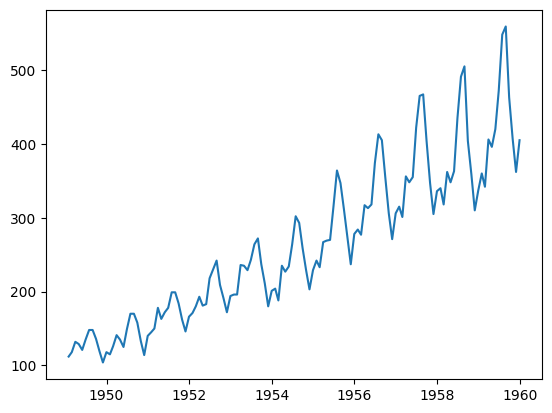

In [6]:
plt.plot(air_train_df['ds'],air_train_df['y']);

In [7]:
models_trend_seasonal = [
    MSTL(season_length=[12])
]

sf_trend_seasonal = StatsForecast(
    models=models_trend_seasonal, 
    freq='M', #monthly frequency
)

sf_trend_seasonal.fit(air_train_df)

StatsForecast(models=[MSTL])

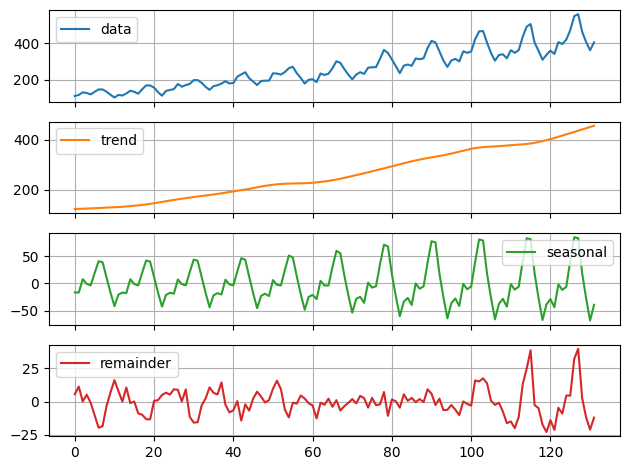

In [8]:
sf_trend_seasonal.fitted_[0, 0].model_.plot(subplots=True, grid=True)
plt.tight_layout()
plt.show()